<center><h2> Hypothesis 1 </h2></center>

- H0: Air quality of boroughs in Inner London = Air quality of boroughs in Outer London
- H1: Air quality of boroughs in Inner London != Air quality of boroughs in Outer London

Inner London and Outer London is as defined by the borough dataset.

In [151]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import statistics as stats
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [152]:
import data_cleaning as dc
import api

import hypothesis_tests as ht
import hypothesis_full as hy
import visualizations as vis


In [153]:
# getting all the air quality data for all Inner London boroughs into one array
# 14 inner city boroughs, 19 outer city boroughs, each with 24 air quality data point observed over last 24hours

aqi = hy.read_aqi24_data()
inner_aqi, outer_aqi = hy.aqi_by_group(aqi,'inner_outer','Inner London','Outer London')

In [154]:
# checkout how many data points in each sample
display(len(inner_aqi))
display(len(outer_aqi))

336

456

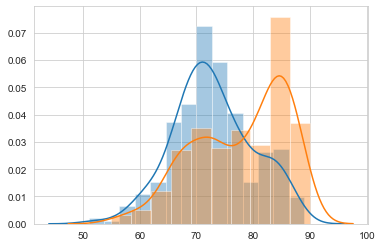

In [155]:
vis.distplots(inner_aqi, outer_aqi)

In [156]:
# looking at the mean, standard deviation and variance of Inner London vs. Outer London

display(ht.sample_mu_std_var(inner_aqi))
display(ht.sample_mu_std_var(outer_aqi))

(72.91369047619048, 7.0648562280659775, 49.912193523242635)

(77.80701754385964, 8.14439554689319, 66.33117882425361)


The distribution of the two samples are not quite normal distributions, especially the Outer London sample. Also its not clear the variance are the same between two samples

Given that we have around 300 to 450 data points, we will conduct random samples, calculated the mean and use the sample means for our t-test. As by central limit theorem the sample means should follow a normal distribution and hence satisfy the normality assumption for t-tests.

In [180]:
# taking random sample of size 50, calculating the mean, repeating this 1000 times
inner = hy.create_sample_means(inner_aqi,1000)
outer = hy.create_sample_means(outer_aqi,1000)

In [181]:
display(ht.sample_mu_std_var(inner))
display(ht.sample_mu_std_var(outer))

(72.93960000000001, 1.00736003494282, 1.0147742399999997)

(77.87913999999999, 1.1575102852242827, 1.3398300604000002)

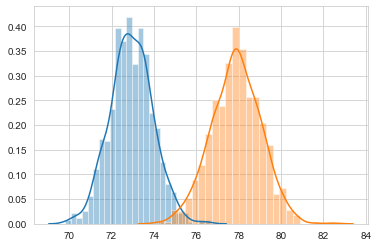

In [182]:
vis.distplots(inner, outer)

By taking sample means of the actual air quality data, we are much more comfortable with the normality assumption.

For hypothesis testing, we will use the Welch's T-test as although the sample size n is the same, the population variance of inner london and outer london may or may not be the same. While assuming the population variance is the same (student t-test) seems reasonable as inner london and outer london are still close together. Welch's t-test just offers flexibility than student t-test.

In [185]:
t = hy.welch_t(inner, outer)
df = hy.welch_df(inner, outer)
print(t, df)

p = hy.p_value(inner, outer, True)
print('p-value is: ', p)

hy.compare_pval_alpha(p, alpha = 0.025)

101.74434595390508 1960.6340043803734
p-value is:  0.0


'Reject'

We have a near zero p-value meaning that we can reject the Null hypothesis that air quality is the same between Inner London boroughs and Outer London boroughs.

----------


SENSE checking the zero p value with Student t-test using ttest_ind

- on the original data sample set, pvalue is very small already, for example, pvalue=7.111555995065837e-18
- on the sample mean dataset, pvalue is zero

In [187]:
display(stats.ttest_ind(inner_aqi, outer_aqi))
display(stats.ttest_ind(inner, outer))

Ttest_indResult(statistic=-8.822210699419344, pvalue=7.111555995065837e-18)

Ttest_indResult(statistic=-101.74434595390508, pvalue=0.0)

Next we calculate: effect size, power for two original sames

In [234]:
print('effect_size of original data:',ht.Cohen_d(inner_aqi,outer_aqi))
print('effect_size of sample means:',ht.Cohen_d(inner,outer))

effect_size of original data: -0.6350925257573231
effect_size of sample means: -4.552422258050261


In [209]:
from statsmodels.stats.power import TTestIndPower, TTestPower

power_analysis = TTestIndPower()
effect_size = ht.Cohen_d(inner_aqi,outer_aqi)
power_analysis.solve_power(alpha=.01, effect_size=effect_size, power=0.90, alternative='two-sided')

75.45781006402525

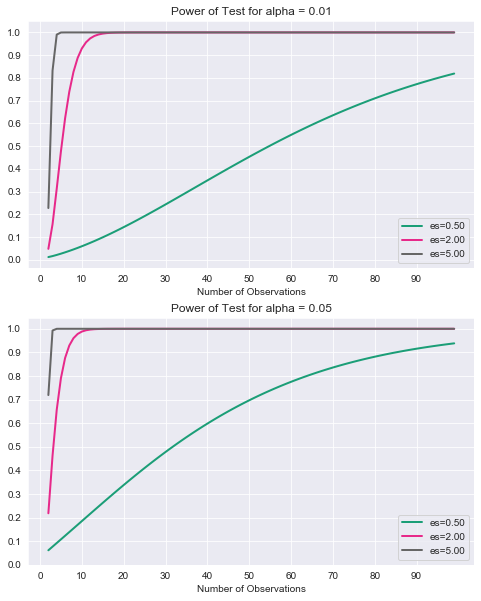

In [233]:
#Your code; plot power curves for the various alpha and effect size combinations

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline


e_sizes = [0.5,2,5]
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(8,10))
for n, alpha in enumerate([.01,0.05]):
    ax = axes[n]
    power_analysis.plot_power(dep_var="nobs",
                              nobs = np.array(range(2,100)),
                              effect_size=e_sizes,
                              alpha=alpha,
                              ax=ax)
    ax.set_title('Power of Test for alpha = {}'.format(alpha))
    ax.set_xticks(list(range(0,100,10)))
    ax.set_yticks(np.linspace(0,1,11))
    
# as alpha increases, required sample size decreases
# as effect size increases, required sample size for a decent power decreases